# **mp3 preprocess**

In [0]:
#@title import libraries
# !pip install librosa
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa.display
import IPython.display as ipd
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [18]:
#@title load files
#####
from google.colab import files
uploaded = files.upload()
#####

Saving G_rnnGAN_0.pt to G_rnnGAN_0.pt


In [0]:
#@title preprocess MP3/wav
# d
y1, sr1 = librosa.load('1.mp3', mono=True)
y2, sr2 = librosa.load('2.mp3', mono=True)
y3, sr3 = librosa.load('3.mp3', mono=True)
y4, sr4 = librosa.load('4.mp3', mono=True)
y5, sr5 = librosa.load('5.mp3', mono=True)
y6, sr6 = librosa.load('6.mp3', mono=True)
y7, sr7 = librosa.load('7.mp3', mono=True)
y8, sr8 = librosa.load('8.mp3', mono=True)
# # g
y9, sr9 = librosa.load('9.mp3', mono=True)
y10, sr10 = librosa.load('10.mp3', mono=True)

y1 = y1[0:3989000]
y2 = y2[0:3989000]
y3 = y3[0:3989000]
y4 = y4[0:3989000]
y5 = y5[0:3989000]
y6 = y6[0:3989000]
y7 = y7[0:3989000]
y8 = y8[0:3989000]
y9 = y9[0:3989000]
y10 = y10[0:3989000]

In [0]:
#@title data checking
#####
print(sr6)
# print(len(mfcc))
#####

# **RNN GAN**

In [0]:
#@title preprocess
### y
### preprocess for RNN #1
time_steps = 100
music_length = len(y1)
sequence_size = int(music_length/time_steps)

# g_sample = np.zeros((sequence_size,time_steps))
# d_sample = np.zeros((sequence_size,time_steps))

g1_sample = np.zeros((sequence_size,1,time_steps))
g2_sample = np.zeros((sequence_size,1,time_steps))
d_sample = np.zeros((sequence_size,8,time_steps))
for i in range(sequence_size):
#   g_sample[i] = y8[time_steps*i:time_steps*(i+1)]
#   d_sample[i] = y1[time_steps*i:time_steps*(i+1)]
  
  g1_sample[i,0,:] = y9[time_steps*i:time_steps*(i+1)]
  g2_sample[i,0,:] = y10[time_steps*i:time_steps*(i+1)]
  d_sample[i,0,:] = y1[time_steps*i:time_steps*(i+1)]
  d_sample[i,1,:] = y2[time_steps*i:time_steps*(i+1)]
  d_sample[i,2,:] = y3[time_steps*i:time_steps*(i+1)]
  d_sample[i,3,:] = y4[time_steps*i:time_steps*(i+1)]
  d_sample[i,4,:] = y5[time_steps*i:time_steps*(i+1)]
  d_sample[i,5,:] = y6[time_steps*i:time_steps*(i+1)]
  d_sample[i,6,:] = y7[time_steps*i:time_steps*(i+1)]
  d_sample[i,7,:] = y8[time_steps*i:time_steps*(i+1)]
  
# g_sample = g_sample.reshape(sequence_size,time_steps,1)
# d_sample = d_sample.reshape(sequence_size,time_steps,1)

d_sample = Variable(torch.Tensor(d_sample)).cuda()
g1_sample = Variable(torch.Tensor(g1_sample)).cuda()
g2_sample = Variable(torch.Tensor(g2_sample)).cuda()

# 
# print(d_sample)


In [0]:
print(d_sample[0:5,0,0])

tensor([0., 0., 0., 0., 0.], device='cuda:0')


In [0]:
#@title train the models
# https://github.com/devnag/pytorch-generative-adversarial-networks/blob/master/gan_pytorch.py

# ##### DATA: Target data and generator input data

# d_sample = torch.Tensor(d_sample)
# g_sample = torch.Tensor(g_sample)

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.LSTM(input_size,hidden_size,n_layer,batch_first=True)
        # self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.map2 = nn.Sequential(nn.Linear(hidden_size,64),
                                 nn.LeakyReLU(),
#                                  nn.Linear(64,100),
#                                  nn.Tanh(),
                                 nn.Linear(64,output_size),
                                 nn.Tanh())
#         self.f = f

    def forward(self, x):
        x,_ = self.map1(x)
#         x = self.f(x)
        x = self.map2(x)
#         x = self.f(x)
#         x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.LSTM(input_size,hidden_size,n_layer,batch_first=True)
        # self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.map2 = nn.Sequential(nn.Linear(hidden_size,64),
                                nn.LeakyReLU(),
#                                 nn.Linear(64,100),
#                                 nn.Sigmoid(),
                                nn.Linear(64,output_size),
                                nn.Sigmoid())
#         self.f = f

    def forward(self, x):
#         x = self.f(self.map1(x))
#         x = self.f(self.map2(x))
#         x = self.f(self.map3(x))
        x,_ = self.map1(x)
        x = self.map2(x)
#         x = self.map3(x)
        return x

# Model parameters
g_input_size =  g1_sample.size(-1)     # Random noise dimension coming into generator, per output vector
g_hidden_size = 32     # Generator complexity
g_output_size = g1_sample.size(-1)     # Size of generated output vector
g_n_layer = 2
d_input_size = d_sample.size(-1)    # Minibatch size - cardinality of distributions
d_hidden_size = 32   # Discriminator complexity
d_output_size = d_sample.size(-1)     # Single dimension for 'real' vs. 'fake' classification
d_n_layer = 2

d_learning_rate = 1e-2
g_learning_rate = 1e-2

num_epochs = 200
d_steps = 4
g_steps = 1

# dfe, dre, ge = 0, 0, 0
# d_real_data, d_fake_data, g_fake_data = None, None, None

# discriminator_activation_function = torch.sigmoid
# generator_activation_function = torch.tanh

G = Generator(input_size=g_input_size,
              hidden_size=g_hidden_size,
              n_layer = g_n_layer,
              output_size=g_output_size).cuda()
              #f=generator_activation_function)
D = Discriminator(input_size=d_input_size,
                  hidden_size=d_hidden_size,
                  n_layer = d_n_layer,
                  output_size=d_output_size).cuda()
                  #f=discriminator_activation_function)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
opt_D = optim.RMSprop(D.parameters(), lr=d_learning_rate)
opt_G = optim.RMSprop(G.parameters(), lr=g_learning_rate)

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        opt_D.zero_grad()

        #  1A: Train D on real
        D_real = D(d_sample)
        #  1B: Train D on fake
        G_fake = G(g2_sample)
        D_fake = D(G_fake)
        D_loss = -torch.mean(torch.log(D_real)+torch.log(1.-D_fake)) 
        D_loss.backward(retain_graph=True) # compute/store gradients
        torch.nn.utils.clip_grad_norm(D.parameters(), 1)
        opt_D.step() # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        opt_G.zero_grad()

        G_fake = G(g2_sample)
        D_fake = D(G_fake)
        G_loss = torch.mean(torch.log(1. - D_fake))

        G_loss.backward()
        torch.nn.utils.clip_grad_norm(G.parameters(), 1)
        opt_G.step() # Only optimizes G's parameters
        
    
#     G_fake = G(g_sample)
#     D_real = D(d_sample)
#     D_fake = D(G_fake)

#     D_loss = - torch.mean(torch.log(D_real) + torch.log(1. - D_fake))
#     G_loss = torch.mean(torch.log(1. - D_fake))

#     opt_D.zero_grad()
#     D_loss.backward(retain_graph=True)
#     torch.nn.utils.clip_grad_norm(D.parameters(), 1)
#     opt_D.step()

#     opt_G.zero_grad()
#     G_loss.backward()
#     torch.nn.utils.clip_grad_norm(G.parameters(), 1)
#     opt_G.step()
    
#     print("D: "+str(D_loss))
#     print("G: "+str(G_loss))
    
    print(D_real[0:10,0,0])
    print(D_fake[0:10,0,0])


In [0]:
#@title print results
print(D_real[0:3,0,0])
print(D_fake[0:3,0,0])
print(D_loss)
print(G_loss)
print(d_sample[-100:-1,0,0])
print(G_fake[-100:-1,0,0])

tensor([0.6498, 0.6498, 0.6498], device='cuda:0', grad_fn=<SelectBackward>)
tensor([0.0007, 0.0007, 0.0007], device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0766, device='cuda:0', grad_fn=<NegBackward>)
tensor(-0.0246, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([-0.4471,  0.2627,  0.0618, -0.1626, -0.1837, -0.0323,  0.3214,  0.2597,
        -0.2489,  0.1668, -0.1642,  0.1319, -0.3316, -0.5018, -0.2840, -0.1915,
         0.2027, -0.4743, -0.3291, -0.5135,  0.0281, -0.1489, -0.4479, -0.3465,
        -0.2079, -0.0310, -0.1214, -0.4245, -0.0109, -0.3430,  0.0631, -0.2416,
        -0.2649, -0.1291, -0.1342,  0.0343, -0.2273, -0.1896, -0.2285, -0.0542,
         0.1516, -0.2109, -0.2763, -0.0798,  0.2441,  0.2314, -0.3124,  0.3696,
         0.0644,  0.5993,  0.1675,  0.2088,  0.2133,  0.1666,  0.1742, -0.0224,
         0.0786,  0.2494, -0.5156, -0.5235, -0.4272, -0.1535, -0.2921, -0.1201,
        -0.5286, -0.8381, -0.5316, -0.5616,  0.0037,  0.4413,  0.2017,  0.0085,
        -0.1289

In [0]:
#@title show results
result = G(g2_sample).cpu()
result = result.data.numpy() 
result = np.array(result).flatten()
librosa.output.write_wav('result_v3.wav',result,sr8)
ipd.Audio('result_v3.wav')
# librosa.display.waveplot(result, sr=sr8)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#@title save G
# save
torch.save(G.state_dict(), "G.pt")

In [0]:
#@title load G
# load
model = Generator(input_size=g_input_size,
              hidden_size=g_hidden_size,
              n_layer = g_n_layer,
              output_size=g_output_size).cuda()
model.load_state_dict(torch.load("G.pt"))
# model.eval()

In [0]:
#@title test on other samples
y1, sr1 = librosa.load('Money.mp3', mono=True,duration = 10)
test1_sample = np.array(y1)
print(y1)
time_steps = 500

music_length = len(y1)
sequence_size = int(music_length/time_steps)

test1_sample = np.zeros((sequence_size,time_steps))
for i in range(sequence_size):
    test1_sample[i] = y1[time_steps*i:time_steps*(i+1)]
  
test1_sample = test1_sample.reshape(sequence_size,time_steps,1)
test1_sample = Variable(torch.tensor(test1_sample)).float().cuda()

result = model(test1_sample).cpu()
result = result.data.numpy() 
result = np.array(result).flatten()
librosa.output.write_wav('result_v3.wav',result,src)
ipd.Audio('result_v3.wav')

# waveplot


In [0]:
music, sr = librosa.load('music.wav', mono=True)
BGM, sr = librosa.load('BGM.wav', mono=True)
simpleGAN, sr = librosa.load('result_v1_simple_gan.wav', mono=True)
modifiedGAN, sr = librosa.load('result_v2_modified_gan.wav', mono=True)
rnnGAN, sr = librosa.load('result_v3_rnn_gan.wav', mono=True)

In [0]:
tensec,_ = librosa.load('Money.mp3', mono=True)

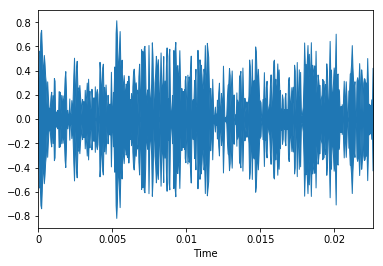

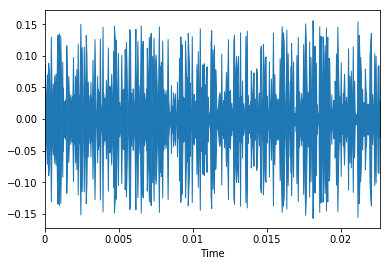

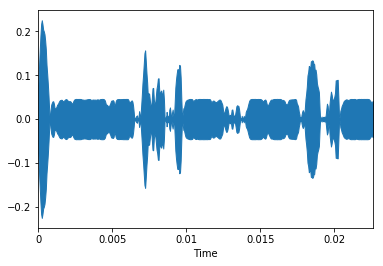

In [19]:
plt.figure()
librosa.display.waveplot(music[0:500], sr=sr)
# plt.figure()
# librosa.display.waveplot(BGM[0:500], sr=sr)
plt.figure()
librosa.display.waveplot(modifiedGAN[0:500], sr=sr)
plt.figure()
librosa.display.waveplot(rnnGAN[0:500], sr=sr)

# Y = librosa.stft(y)
# Ydb = librosa.amplitude_to_db(abs(Y))
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
# plt.colorbar()